## Vehicle detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import numpy as np
import cv2
import glob
from ipywidgets import interactive, interact
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip, CompositeVideoClip
from IPython.display import HTML
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.model_selection import train_test_split


In [2]:
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import tensorflow as tf

import sys
sys.path.append('./ssd_keras')

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

print(tf.__version__)
print(keras.__version__)
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('./ssd_keras/weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

USE_SSD = True

Using TensorFlow backend.


1.0.0
1.2.2


## Training data

I downloaded the data provided by Udacity of vehicles and non-vehicles. The data is properly balanced so there's no need to further balance it.

In [3]:
# Read in car and non-car images
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)


In [4]:
print(len(cars), len(notcars))

8792 8968


## Feature-extraction functions: HOG, Color histogram and Binned color features

The cells below are take from the lessons more of less directly. The only notable comment is that PNG images are properly scaled to [0,255] (instead of [0,1]) to be consistent with JPG and the video pipeline.

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, colorspace='RGB',
                     hog_channel = 'ALL', 
                     orient = 8, pix_per_cell = 8, cell_per_block = 1, spatial_size=(32, 32),
                     hist_bins=32, hist_range=(0, 256), spatial_feat=False, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one, or pass straight if 'file' is really an image
        if type(file) is str:
            image = mpimg.imread(file)
            if file.endswith("png"):
                image = (image * 255).astype(np.uint8)
        else:
            image = file
        image = cv2.resize(image, (64,64))
        # apply color conversion if other than 'RGB'
        if colorspace != 'RGB':
            if colorspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif colorspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif colorspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif colorspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif colorspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        features.append(np.concatenate(file_features))

    # Return list of feature vectors
    return features


## Training 

The train_svm function trains a linear classifier with the extracted features and returns its accuracy, the classifier and the scaler used.

I did a parameter search for ~12 hours and settled in the following parameters: 
- 9 orientations 
- 8 pixels per cell
- 2 cells per block 
- YCrCb colorspace using ALL channel(s) 
- 16 bins (for histogram feature)


In [7]:
def train_svm(colorspace, orient, 
              pix_per_cell, cell_per_block, 
              hog_channel, hist_bins, spatial_size):
    t=time.time()
    car_features = extract_features(cars, colorspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins, spatial_size=spatial_size)
    notcar_features = extract_features(notcars, colorspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_bins=hist_bins, spatial_size=spatial_size)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((np.asarray(car_features), np.asarray(notcar_features))).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = 0 #np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
          'pixels per cell and', cell_per_block,'cells per block',
          'in the', colorspace, 'colorspace using', hog_channel, 'channel(s),', hist_bins,'bins and', spatial_size,'spatial patch')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    acc = svc.score(X_test, y_test)
    print('Test Accuracy of SVC = ', round(acc, 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.decision_function(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return acc, svc, X_scaler

In [8]:
# Set to True to do an exhaustive (brute-force) search of best paramaters
brute_force_search = False

if brute_force_search:

    from sklearn.grid_search import ParameterGrid

    grid = ParameterGrid({"hog_channel": ['ALL'],
                          "colorspace": ["YUV", "YCrCb" ],
                          "orient": [9,11,13],
                          "pix_per_cell": [4,8,16],
                          "cell_per_block": [2, 3, 4],
                          "hist_bins" : [8,16,32,64],
                          "spatial_size": (32,32)
                          })

    best_acc = 0.
    for params in grid:
        (cacc, svc, scaler) = train_svm(**params)
        if cacc > best_acc:
            best_acc    = cacc
            best_params = params

    print('Best accuracy=', best_acc, 'with params:', params )


In [9]:
# after ~12 hours of grid search these parameters parameters are a good tradeoff between accuracy and memory/speed.
#
# 154.43 Seconds to extract HOG features...
# Using: 9 orientations 8 pixels per cell and 2 cells per block in the YCrCb colorspace using ALL channel(s), 16 bins and (32, 32) spatial patch
# Feature vector length: 5340
# 27.63 Seconds to train SVC...
# Test Accuracy of SVC =  0.9924
# My SVC predicts:  [ 3.25541657  1.68986827 -3.62908851  2.54200072  3.32680589 -1.60840969
#   3.64761966 -3.63127082  4.33903266  3.18758232]
# For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
# 0.0292 Seconds to predict 10 labels with SVC
# 0.992398648649

if USE_SSD == False:
    colorspace = 'YCrCb'
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    hist_bins = 16
    spatial_size = (32,32)
    (acc, svc, scaler) = train_svm(
        colorspace = colorspace,
        orient = orient,
        pix_per_cell = pix_per_cell,
        cell_per_block = cell_per_block,
        hog_channel = hog_channel,
        hist_bins = hist_bins,
        spatial_size = spatial_size)

    print(acc)

## Sliding window (1/2)

I first tried a naive sliding-window search just to get acquainted. 

The cells below explore such approach with a single scale. I also noticed I had some false positives so I decided to get the decision function from the classifier and explore with different thresholds. I settled on 1.1 (i.e. vehicles will be detected if the decision function is >= 1.1 instead of >= 0 which is the default behavior of predict), thus minimizing false negatives.

<function __main__.detect_cars_ssd_interact>

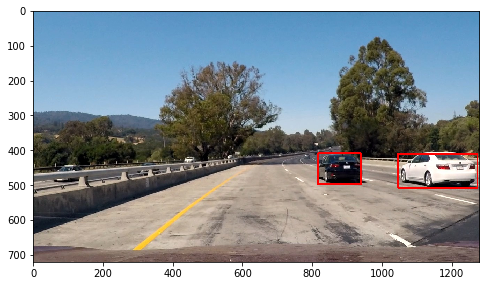

In [10]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6, threshold = 0):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        features = extract_features([img[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]], 
                                    colorspace=colorspace,
                                    hog_channel = hog_channel,
                                    orient = orient, 
                                    pix_per_cell = pix_per_cell, 
                                    cell_per_block = cell_per_block,
                                    hist_bins = hist_bins,
                                    spatial_size = spatial_size)
        feature_scaled = scaler.transform(np.float64(features).reshape(1, -1))
        pred = svc.decision_function(feature_scaled)
        #print(pred[0])
        if pred[0] >= threshold:
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def detect_cars(image, threshold):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.90, 0.90))
                       
    window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6, threshold = threshold)                    
    #plt.imshow(window_img)
    return window_img

def detect_cars_hog_interact(fname, threshold):
    image = mpimg.imread(fname)
    plt.imshow(detect_cars(image, threshold))
    return

def detect_cars_ssd(image, threshold):
    img = preprocess_input(np.array([cv2.resize(image, (300,300))], dtype=np.float32))

    preds = model.predict(img, batch_size=1)
    results = bbox_util.detection_out(preds)
    
    i = 0
    
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= threshold]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    #colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    #plt.imshow(image / 255.)
    #currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * image.shape[1])) 
        ymin = int(round(top_ymin[i] * image.shape[0]))
        xmax = int(round(top_xmax[i] * image.shape[1]))
        ymax = int(round(top_ymax[i] * image.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        if label_name == 'Car':
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (255,0,0), 3)

        #display_txt = '{:0.2f}, {}'.format(score, label_name)
        #coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        #color = colors[label]
        #currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        #currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    return image 

def detect_cars_ssd_interact(fname, threshold):
    plt.imshow(detect_cars_ssd(mpimg.imread(fname), threshold))
    return

detect_cars_interact = detect_cars_ssd_interact if USE_SSD else detect_cars_hog_interact

interact(detect_cars_interact, 
         fname=glob.glob('test_images/*.jpg'), 
         threshold = widgets.FloatSlider(min = -5., max=5, value = 0.60))


## Sliding window (2/2)

I then implemented a multi-scale window search, I tested multiple scales and settled on four different scales: 
* 0.75
* 1.5
* 2
* 3 

The cells below build a heatmap of detections on different scales and then uses openCV countour detection functions to draw contours around the areas of the heatmap where a given theshold is surpassed.


In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scales, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, 
              threshold = 0, debug_windows=False, only_heatmap=False):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch_orig = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    maxscale = max(scales)

    def heatmap(scale):
        draw_img = np.zeros_like(img, dtype=np.uint8)
        if scale != 1.:
            imshape = ctrans_tosearch_orig.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch_orig, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        else:
            ctrans_tosearch = ctrans_tosearch_orig

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the original sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 0.5 * maxscale / scale  # Instead of overlap, define how many cells to step
        nxsteps = int((nxblocks - nblocks_per_window) / (cells_per_step ))
        nysteps = int((nyblocks - nblocks_per_window) / (cells_per_step ))

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = int(yb*cells_per_step)
                xpos = int(xb*cells_per_step)
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = []#bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((hog_features, spatial_features, hist_features )).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.decision_function(test_features)

                if (test_prediction >= threshold) & (debug_windows == False):
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    rec = np.zeros_like(draw_img)
                    draw_img[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw,0] = \
                        cv2.add(draw_img[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw,0], 50)

                if (debug_windows == True):
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

        return draw_img
    
    heats = []
    if multithread == False:
        for scale in scales:
            heats.append(heatmap(scale))
    else:
        from multiprocessing.dummy import Pool as ThreadPool 
        from multiprocessing import cpu_count

        pool = ThreadPool(cpu_count())
        heats = pool.map(heatmap, scales)
        pool.close()
        pool.join()

    
    threshold = np.zeros_like(draw_img[:,:,0])
    for heat in heats:
        threshold = cv2.add(threshold, heat[:,:,0])
        
    if only_heatmap == True:
        return threshold
        
    threshold[threshold < 250] = 0
        
    im2, contours, hierarchy = cv2.findContours(threshold,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    draw_img = cv2.drawContours(draw_img, contours, -1, (0,255,0), 3)

    return draw_img
    
if USE_SSD == False:
    ystart = 400
    ystop = 656
    scale = [0.75,1.5,2,3]
    multithread = True

    def find_cars_interact(fname, threshold):
        img = mpimg.imread(fname)
        out_img = find_cars(img, ystart, ystop, scale, svc, scaler, 
                            orient, pix_per_cell, cell_per_block, spatial_size, 
                            hist_bins, 
                            threshold = threshold)
        plt.imshow(out_img)

    params = interactive(find_cars_interact, 
             fname=glob.glob('test_images/*.jpg'),
             threshold = widgets.FloatSlider(min = -5., max=5, value = 1.1))

    params



## Video pipeline

The video pipeline reuses most of the image detection functions above. The most notable improvent is to build a cummulative heatmap of the past 10 frames (250msecs) and do threshold detection around that cummulative heatmap. In addition, I built positive hysteresis in the detector, so that when a given area is detected, the heatmap is kept on unless the next 10 frames don't contain detection.

In [12]:
from moviepy.editor import VideoFileClip, CompositeVideoClip
from IPython.display import HTML

if USE_SSD==False:
    iparams = dict(params.kwargs)
    del iparams['fname']

    FRAMES = 10
    heatmaps = np.zeros([720,1280,FRAMES], dtype=np.int32)
    frame = 0
    def find_cars_fl(img):
        global frame, heatmaps
        heatmaps[:,:,frame] = find_cars(img, ystart, ystop, scale, svc, scaler, orient, 
                                        pix_per_cell, cell_per_block, spatial_size, hist_bins, 
                                        only_heatmap = True, **iparams)

        threshold = np.sum(heatmaps, axis=2)

        TH = int(200*FRAMES/4)
        threshold[threshold < TH] = 0

        for fr in range(FRAMES):
            if fr != frame:
                heatmaps[(threshold >= TH) & (heatmaps[:,:,fr] < (TH/(FRAMES-1))) , fr] = TH/(FRAMES-1) # hysteresis 

        im2, contours, hierarchy = cv2.findContours(threshold.astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

        draw_img = cv2.drawContours(img, contours, -1, (0,255,0), 3)

        frame = (frame + 1) % FRAMES

        return draw_img
else:
    def find_cars_ssd_fl(img):
        return detect_cars_ssd(img, 0.6)


    output = './project_video_lanes_out.mp4'
    clip = VideoFileClip("./project_video_lanes.mp4").subclip(45,46)
    detected   = clip.fl_image(find_cars_ssd_fl)
    detected.write_videofile(output, audio=False)


[MoviePy] >>>> Building video ./project_video_lanes_out.mp4
[MoviePy] Writing video ./project_video_lanes_out.mp4


 96%|█████████▌| 25/26 [01:08<00:02,  2.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_lanes_out.mp4 



In [14]:
HTML("""
<video width="640" controls>
  <source src="{0}">
</video>"
""".format(output))

## Final remarks and comments

Based on the research I've done, I don't think HOG detection with linear classifiers (let aside color or spatial histograms) are robust enough for real-would usage. I briefly tested deep neural network-based object detection (namely port of a method called SSD implemented in Keras) which provided great results with even faster speeds and better performance than my implementation.